# WASSA 2023 - Exploratory data analysis (EDA)
### Shared Task on Empathy, Emotion and Personality Detection in Interactions

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

Import dataset

In [2]:
train_essay_data = pd.read_csv('./datasets/WASSA23_essay_level_original_train_preproc.tsv', sep="\t")
dev_essay_data = pd.read_csv('./datasets/WASSA23_essay_level_dev_preproc.tsv', sep="\t")
test_essay_data = pd.read_csv('./datasets/WASSA23_essay_level_test_preproc.tsv', sep="\t")
train_essay_data22 = pd.read_csv('./datasets/WASSA22_essay_level_train_preproc.tsv', sep="\t")
dev_essay_data22 = pd.read_csv('./datasets/WASSA22_essay_level_dev_preproc.tsv', sep="\t")

View dataset format

In [3]:
train_essay_data.head()

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,disgust_count,joy_count,hope_count,empathy_count,distress_count,empathy_level,distress_level,prompt_bio,prompt_emp,prompt_emo
0,263,34,I feel sorry for the people living in that reg...,6.666667,6.625,30,1,6,3,37,...,0.032258,0.129032,0.142857,3.148162,2.914275,medium,low,"An essay about the article , written by a 37 ...",The essay expresses medium empathy and low dis...,"The top emotions expressed in the essay, acco..."
1,437,308,This article really brings you back down to ea...,5.000000,5.000,53,2,3,1,27,...,0.080000,0.040000,0.052632,2.961519,2.776587,low,low,"An essay about the article , written by a 27 ...",The essay expresses low empathy and low distre...,"The top emotions expressed in the essay, acco..."
2,281,202,"Dear friend, ...",5.500000,1.750,7,1,2,5,29,...,0.000000,0.117647,0.125000,2.751292,2.832954,low,low,"An essay about the article , written by a 29 ...",The essay expresses low empathy and low distre...,"The top emotions expressed in the essay, acco..."
3,405,92,"After reading the article, you just can't help...",1.000000,1.500,17,1,6,1,29,...,0.083333,0.083333,0.000000,2.924956,2.748423,medium,medium,"An essay about the article , written by a 29 ...",The essay expresses medium empathy and medium ...,"The top emotions expressed in the essay, acco..."
4,2,35,It breaks my heart to see people living in tho...,6.833333,6.625,30,1,6,3,37,...,0.047619,0.095238,0.117647,2.934509,2.718303,medium,low,"An essay about the article , written by a 37 ...",The essay expresses medium empathy and low dis...,"The top emotions expressed in the essay, acco..."


## Datastets dimesions

In [4]:
print('# essays in Train set: %d' %len(train_essay_data))
print('# essays in Dev set: %d' %len(dev_essay_data))
print('# essays in (Train + Dev) set: %d' %(len(train_essay_data) + len(dev_essay_data)))
print('# essays in Test set: %d' %len(test_essay_data))

# essays in Train set: 779
# essays in Dev set: 208
# essays in (Train + Dev) set: 987
# essays in Test set: 100


In [5]:
if True in train_essay_data.isnull().values:
    print('There are NaN values in Train set')
else:
    print('There aren\'t NaN values in Train set')
    
if True in dev_essay_data.isnull().values:
    print('There are NaN values in Dev set')
else:
    print('There aren\'t NaN values in Dev set')

There aren't NaN values in Train set
There aren't NaN values in Dev set


In [6]:
print('# speakers in Train set: %d'%len(train_essay_data['speaker_id'].unique()))
print('# speakers in Dev set: %d'%len(dev_essay_data['speaker_id'].unique()))
print('# speakers in Test set: %d' %len(test_essay_data['speaker_id'].unique()))

# speakers in Train set: 57
# speakers in Dev set: 41
# speakers in Test set: 65


## Essay length statistics

[Text(0.5, 1.0, 'Dev data'),
 Text(0.5, 0, 'Number of words'),
 Text(0, 0.5, 'Number of essays')]

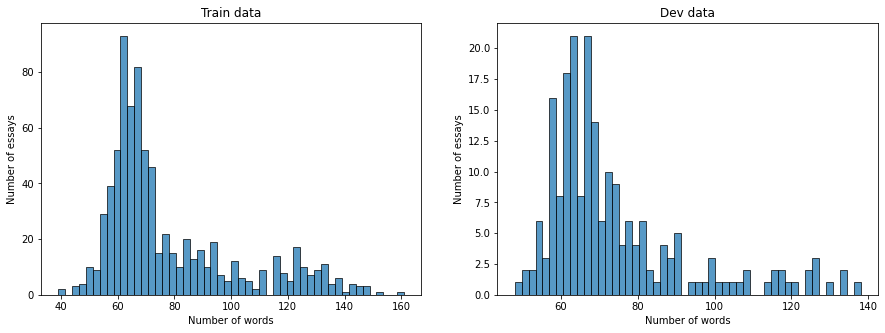

In [7]:
train_essay_data['essay_word_count'] = train_essay_data['essay'].apply(lambda x: len(x.split()))
dev_essay_data['essay_word_count'] = dev_essay_data['essay'].apply(lambda x: len(x.split()))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(train_essay_data['essay_word_count'], bins=50, ax=ax1).set(title='Train data', xlabel='Number of words', ylabel='Number of essays')
sns.histplot(dev_essay_data['essay_word_count'], bins=50, ax=ax2).set(title='Dev data', xlabel='Number of words', ylabel='Number of essays')


Statitics on Train data

In [8]:
train_essay_data['essay_word_count'].describe()

count    779.000000
mean      77.931964
std       23.665986
min       39.000000
25%       62.000000
50%       68.000000
75%       87.500000
max      161.000000
Name: essay_word_count, dtype: float64

Statistics on Dev data

In [9]:
dev_essay_data['essay_word_count'].describe()

count    208.000000
mean      73.836538
std       18.776648
min       48.000000
25%       62.000000
50%       67.000000
75%       79.000000
max      138.000000
Name: essay_word_count, dtype: float64

## Emotions statistics

Get different emotions

In [10]:
emotions = []
for perceived_emotion in train_essay_data['emotion'].unique():
	for emotion in perceived_emotion.split('/'):
		if emotion not in emotions:
			emotions.append(emotion)
emotions

['hope', 'sadness', 'anger', 'neutral', 'disgust', 'fear', 'joy', 'surprise']

One hot encode emotions

In [11]:
for emotion in emotions:
	train_essay_data[emotion] = train_essay_data["emotion"].str.contains(emotion).astype(int)
	dev_essay_data[emotion] = dev_essay_data["emotion"].str.contains(emotion).astype(int)

Emotions distributions

In [12]:
train_counts = pd.DataFrame(train_essay_data[emotions].sum(), columns=['Training set'])
train_perc = pd.DataFrame(train_essay_data[emotions].sum()/len(train_essay_data)*100, columns=['% Training set'])
dev_counts = pd.DataFrame(dev_essay_data[emotions].sum(), columns=['Development set'])
dev_perc = pd.DataFrame(dev_essay_data[emotions].sum()/len(dev_essay_data)*100, columns=['% Development set'])
pd.concat([train_counts, dev_counts, train_perc, dev_perc], axis=1)

,Training set,Development set,% Training set,% Development set
hope,32,16,4.107831,7.692308
sadness,375,101,48.138639,48.557692
anger,119,38,15.275995,18.269231
neutral,240,54,30.808729,25.961538
disgust,96,24,12.323492,11.538462
fear,33,8,4.236200,3.846154
joy,10,2,1.283697,0.961538
surprise,18,3,2.310655,1.442308


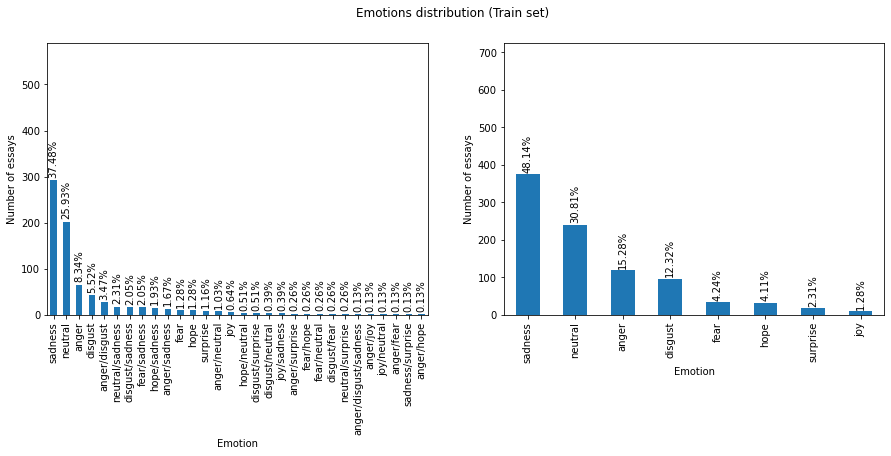

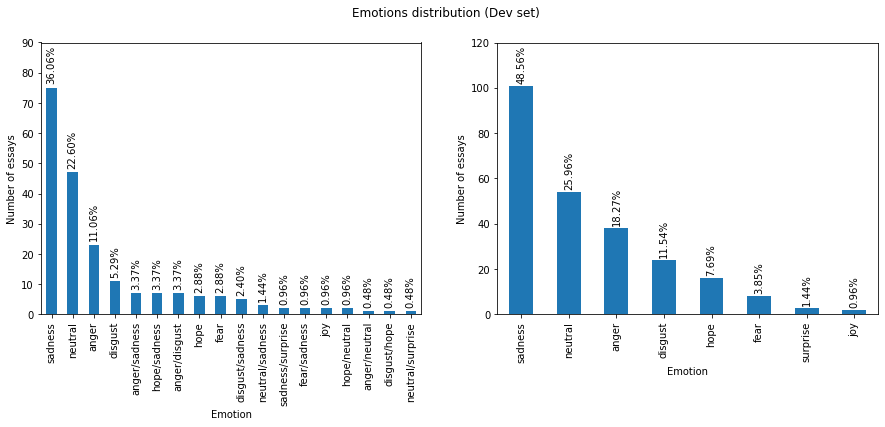

In [13]:
def add_percentages(ax, tot, ylim, height_incr, rotation=90):
	for p in ax.patches:
		width = p.get_width()
		height = p.get_height()
		x, y = p.get_xy() 
		perc = (height / tot)*100
		ax.annotate('%.2f%%'%perc, (x + width/2, y+height+height_incr), ha='center', rotation=rotation)
	ax.set_ylim(0, ylim)

def plot_emotions_distribution(data, title, perc=True, perc_height=5, ylim=(600, 700)):
	_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

	data['emotion'].value_counts().plot(
		kind='bar',
		xlabel='Emotion',
		ylabel='Number of essays',
		ax=ax1
	)

	if perc:
		add_percentages(ax1, len(data['emotion']), ylim[0], perc_height, rotation=90)
	
	data[emotions].sum().sort_values(ascending=False).plot(
		kind='bar',
		xlabel='Emotion',
		ylabel='Number of essays',
		ax=ax2
		)
	
	if perc:
		add_percentages(ax2, len(data[emotions]), ylim[1], perc_height, rotation=90)

	plt.suptitle(title)
	plt.plot()

plot_emotions_distribution(train_essay_data, 'Emotions distribution (Train set)', perc=True, perc_height=10, ylim=(590, 725))
plot_emotions_distribution(dev_essay_data, 'Emotions distribution (Dev set)', perc=True, perc_height=2, ylim=(90, 120))

Number of essays expressing more than one emotion

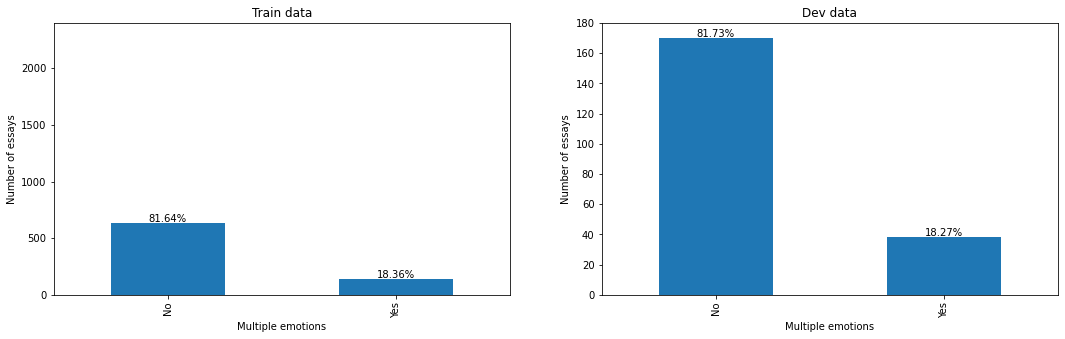

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

train_essay_data['multiple_emotions'] = train_essay_data['emotion'].apply(lambda x: "Yes" if len(x.split("/")) > 1 else "No")
dev_essay_data['multiple_emotions'] = dev_essay_data['emotion'].apply(lambda x: "Yes" if len(x.split("/")) > 1 else "No")

train_essay_data['multiple_emotions'].value_counts().plot(
    kind='bar', title='Train data', xlabel='Multiple emotions', ylabel='Number of essays', ax=ax1)
add_percentages(ax1, len(train_essay_data['multiple_emotions']), 2400, 5, rotation=0)
dev_essay_data['multiple_emotions'].value_counts().plot(
    kind='bar', title='Dev data', xlabel='Multiple emotions', ylabel='Number of essays', ax=ax2)
add_percentages(ax2, len(dev_essay_data['multiple_emotions']), 180, 1, rotation=0)

Words frequency

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irenetesta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Dev data')

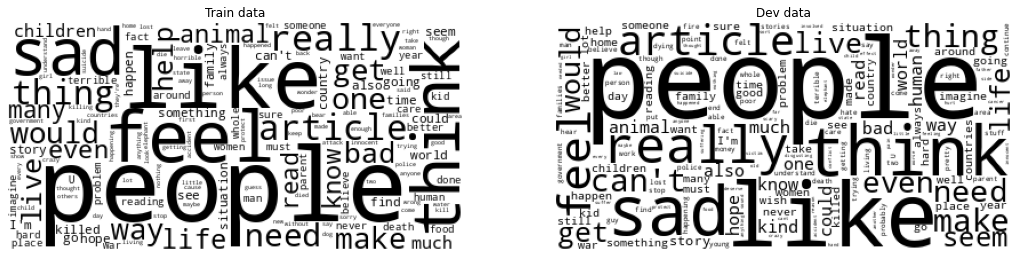

In [15]:
from wordcloud import STOPWORDS # += 'people' ?

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

word_cloud_all_train = WordCloud(
    stopwords=stopwords,
    collocations=False,
    background_color='white',
    color_func=lambda *args,
    **kwargs: "black"
    ).generate(' '.join(train_essay_data['essay'].tolist()))
ax1.imshow(word_cloud_all_train)
ax1.axis('off')
ax1.set_title('Train data')

word_cloud_all_dev = WordCloud(
    stopwords=stopwords,
    collocations=False,
    background_color='white',
    color_func=lambda *args,
    **kwargs: "black"
    ).generate(' '.join(dev_essay_data['essay'].tolist()))
ax2.imshow(word_cloud_all_dev)
ax2.axis('off')
ax2.set_title('Dev data')

Looking at essays labeled with 'joy'

In [16]:
pd.set_option('display.max_colwidth', None)
joy_essays_train = train_essay_data[train_essay_data['joy']==1][['essay','article_id', 'emotion']]
joy_essays_train['split'] = 'Train'
joy_essays_dev = dev_essay_data[dev_essay_data['joy']==1][['essay','article_id', 'emotion']]
joy_essays_dev['split'] = 'Dev'
joy_essays = pd.concat([joy_essays_train, joy_essays_dev], ignore_index=True)
joy_essays

,essay,article_id,emotion,split
0,Its amazing how people facing the toughest hardships can turn their life around and really make something of yourself if you put your mind to it. His brother converted to Islam that probably helps people in Jail when you need some structure to really get yourself in a place where you can learn about yourself,78,joy,Train
1,This girl's life is forever changed. Pellets destroyed her eyes and her face. Her mom wraps scarves around her face and eyes to protect her. :) I have a great deal of admiration for her as she is speaking the the journalist about what happened. She wants her government to give her an answer. She had aspirations of becoming a doctor. She showed her textbooks to him. She is in and out of hospitals hoping to retain her eyesight.,163,joy,Train
2,"I think it's always tragic when someone dies, but when that someone is a milestone type person it's even worse. How wonderful to be the first Chinese woman to be a fighter pilot and then how tragic to be killed in such a way. I have so much respect for trailblazers and it always seems like such a waste for them to be taken from us in such a seemingly meaningless manner. So proud of her accomplishments.",150,joy,Train
3,"The sights and sounds of war are horrible and I would never blame a person for having PTSD. I'm happy that the one solider although he has PTSD, he is working though it and wants to show people that now all people with PTSD are dangerous and there is away to heal yourself after being in a such bad of a place.",386,joy,Train
4,"I am writing as regards my thoughts for Polar bears, the poster-child for climate change, are among the animals most affected by the seasonal and year-to-year changes in Arctic sea ice, because they rely on this surface for essential activities such as hunting, traveling and breeding. The researchers recommend that the National Climate Assessment incorporate the timing of spring ice retreat and fall ice advance as measures of climate change in future reports. The study's results currently are used by the International Union for Conservation of Nature's polar bear specialist group, which completes assessments of polar bears and issues the species' conservation status. I am really pleased with this information.",49,joy/neutral,Train
5,We need more oil and more jobs where do these people have time to go and protest do they work or not I mean I have no time to go protest it is crazy to me that these people can stop the construction of a wonderful pipeline to bring more oil to us I love oil and I love when it is cheap and affordable,273,anger/joy,Train
6,"This is sad, I have not heard of this Indian Pakistani issue but it sounds like it is affecting a lot of people and a lot of lives. I can't imagine living somewhere where you constantly had to fear being bombed or shot or some catastrophe like that that caused imminent death or bodily harm. It would just be so stressful and difficult to have to live like that. I get worried about things like getting sick but jeez this just takes it to an all new level. It makes me very grateful to live where I am instead of somewhere like that.",11,joy/sadness,Train
7,"It's very difficult to fathom living somewhere where airstrikes can take you out at any given moment, regardless of where you are. It really makes me grateful to live in this beautiful nation where we live, America, and to have the freedoms that we have. In this story, the man's eight children lost their father and his wife lost her partner. That is very tragic, and all for a bunch of senseless killing. The US was supporting these airstrikes which is sort of sad. I find the whole situation over there so senseless. IT's like they are all just killing each other nonstop for no valid reason.",367,joy/sadness,Train
8,It is nice for her to share her journey with cancer. I like how both of them connected with each other. I know that cancer is a sad thing and I'm happy they she found a way to change how she thi

Looking at essays labeled with 'neutral' and other emotions

In [17]:
neutral_essays_train = train_essay_data[
    (train_essay_data['emotion'].str.contains('neutral')) & (train_essay_data['emotion'].str.contains('/'))
    ][['essay','article_id', 'emotion']]
neutral_essays_train['split'] = 'Train'
neutral_essays_dev = dev_essay_data[
    (dev_essay_data['emotion'].str.contains('neutral')) & (dev_essay_data['emotion'].str.contains('/'))
    ][['essay','article_id', 'emotion']]
neutral_essays_dev['split'] = 'Dev'
neutral_essays = pd.concat([neutral_essays_train, neutral_essays_dev], ignore_index=True)
neutral_essays

,essay,article_id,emotion,split
0,"I am writing as regards my thoughts for Polar bears, the poster-child for climate change, are among the animals most affected by the seasonal and year-to-year changes in Arctic sea ice, because they rely on this surface for essential activities such as hunting, traveling and breeding. The researchers recommend that the National Climate Assessment incorporate the timing of spring ice retreat and fall ice advance as measures of climate change in future reports. The study's results currently are used by the International Union for Conservation of Nature's polar bear specialist group, which completes assessments of polar bears and issues the species' conservation status. I am really pleased with this information.",49,joy/neutral,Train
1,How can your heart just not break reading this article. These children had there life cut way to short for no reason. This father was just pure evil. He needed serious mental help and I can't believe no one saw this coming. There is always signs that people should take serious so it doesnt come to this. I would like to know the motive was it because he felt overwhelmed or because he wanted to get back at someone. The mother should have taken the threat seriosuly and I wonder if the rangers had found the car sooner if those kids would have been alive. They were probably so afraid in that car and it is horrible that was there last memories alive.,202,neutral/sadness,Train
2,"A smog outbreak in Southeast Asia last year may have caused over 100,000 premature deaths, according to a new study released Monday that triggered calls for action to tackle the ?killer haze?. Researchers from Harvard and Columbia universities in the US estimated there were more than 90,000 early deaths in Indonesia in areas closest to haze-belching fires, and several thousand more in neighboring Singapore and Malaysia. I feel so sad at the thought of this haze killing thousands of people.",147,neutral/sadness,Train
3,"This was a very short article without a lot of context to it. It did not tell why the man with the assault style weapon killed the man that was in his seventy's. At first, I thought it was going to be about a man that was denied the right to vote, but that story proved to be false. I do feel sorry for any body who loses their life to gun violence.",292,neutral/sadness,Train
4,"I'm really sad about this scenario ""The heartache of losing a loved one in a sudden, unexpected moment is devastating. The shock is jarring and confusing. Families and friends are left with broken hearts and aching spirits. Losing one person is painful. But, for a Tampa husband, the grief is paralyzing and unbearable. On Wednesday night, John Bernal lost his wife, his youngest daughter and his youngest son in a horrific car accident on MLK"" It was really a sad situation.",314,neutral/sadness,Train
5,"So, I just read an article about a baby rhino that passed away in captivity; apparently, due to lack of power? The article was very vague, but the woman describing the situation spoke of the rhino like a member of her family. The whole thing was very touching. It's hard not to have an emotional response to the suffering of any creature.",400,neutral/sadness,Train
6,"Dear friend, I have just finished reading an article about Janet Reno. She was the first female US Attorney General. She had a very impressive professional and legal career. I am saddened by her death, she died at the age of seventy eight. She had a productive life.",177,neutral/sadness,Train
7,"The heartbreaking cries of girls who watched their mothers die on Thunder River Rapids ride: Two young girls, aged 10 and 13, were miraculously thrown to safety from the doomed Thunder River Rapids ride at Dreamworld on Australia's Gold Coast and watched in horror as the four adults in their raft were killed. A malfunction with the ride's conveyor belt is suspected to have caused the six-person raft to flip, crushing and drowning two men, aged 38 and 35, an

Emotions lexicon count distributions

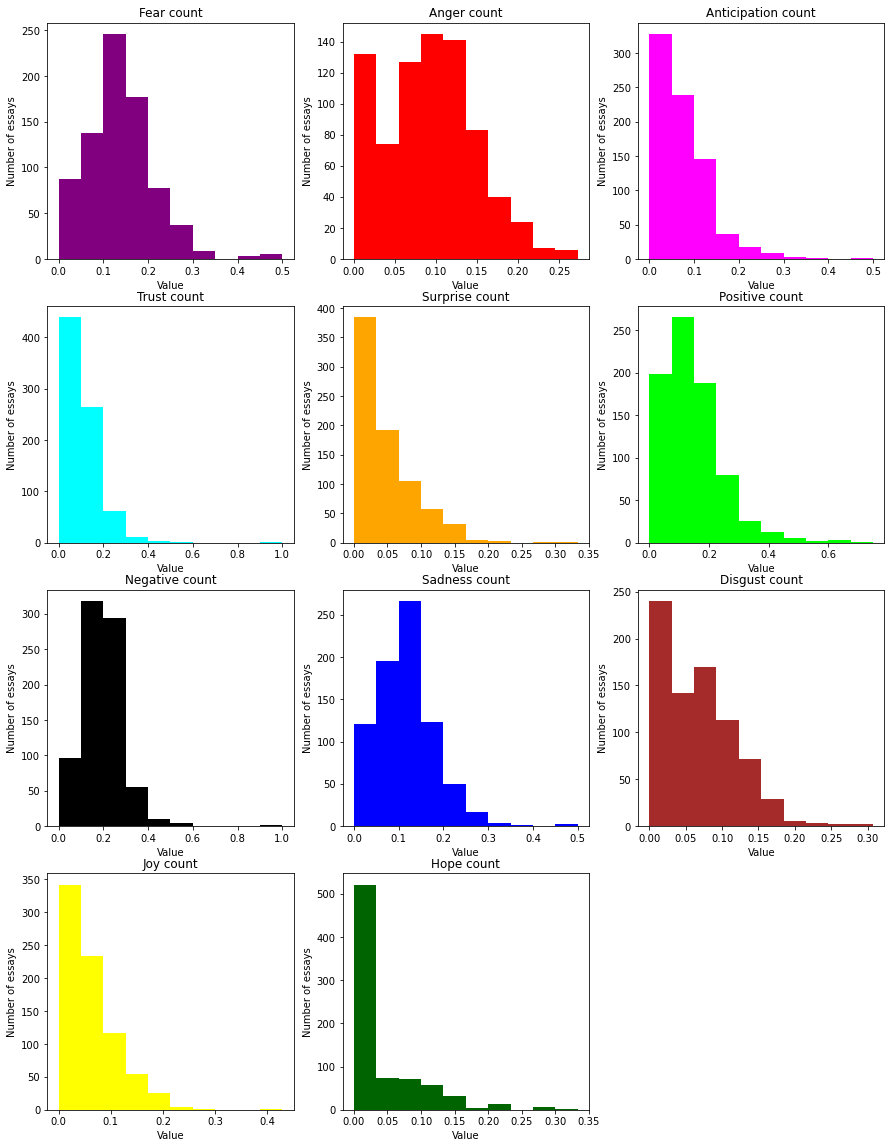

In [18]:
LEXICON_EMOTIONS = [
	'fear',
	'anger',
	'anticipation',
	'trust',
	'surprise',
	'positive',
	'negative',
	'sadness',
	'disgust',
	'joy',
	'hope'
]
COLORS = [
    'purple',
    'red',
    'magenta',
    'cyan',
    'orange',
    'lime',
    'black',
    'blue',
    'brown',
    'yellow',
    'darkgreen']
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
row_count = 0
col_count = 0
for color, emotion in zip(COLORS, LEXICON_EMOTIONS):
    ax = train_essay_data[f'{emotion}_count'].plot.hist(ax=axs[row_count][col_count],color=color)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of essays")
    ax.set_title(f"{emotion.title()} count")
    if col_count == 2:
        row_count += 1
        col_count = 0
    else:
        col_count += 1
fig.delaxes(axs[3][2])


## Empathy and distress statistics

Train data

In [19]:
train_essay_data[["empathy", "distress"]].describe()

,empathy,distress
count,779.000000,779.000000
mean,4.208601,3.750642
std,2.006974,2.041159
min,1.000000,1.000000
25%,2.250000,1.750000
50%,4.500000,3.875000
75%,6.000000,6.000000
max,7.000000,7.000000


Dev data

In [20]:
dev_essay_data[["empathy", "distress"]].describe()

,empathy,distress
count,208.000000,208.000000
mean,4.329327,3.801082
std,1.671205,1.761442
min,1.000000,1.000000
25%,3.500000,2.343750
50%,4.166667,3.625000
75%,6.000000,5.625000
max,7.000000,7.000000


[Text(0.5, 1.0, 'Dev set 23')]

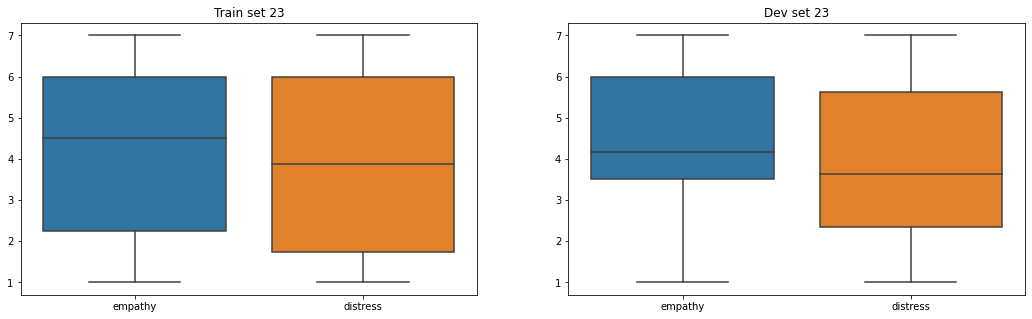

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(data=train_essay_data[["empathy", "distress"]], ax=ax1).set(title='Train set 23')
sns.boxplot(data=dev_essay_data[["empathy", "distress"]], ax=ax2).set(title='Dev set 23')

[Text(0.5, 1.0, 'Dev set 22')]

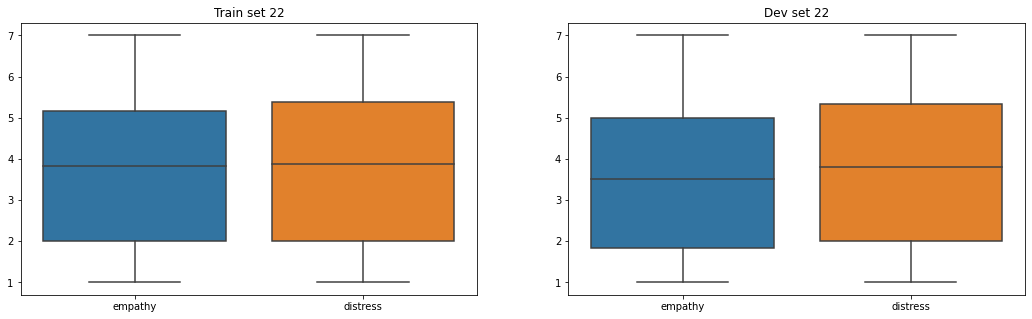

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(data=train_essay_data22[["empathy", "distress"]], ax=ax1).set(title='Train set 22')
sns.boxplot(data=dev_essay_data22[["empathy", "distress"]], ax=ax2).set(title='Dev set 22')

[Text(0.5, 1.0, 'Dev set 23')]

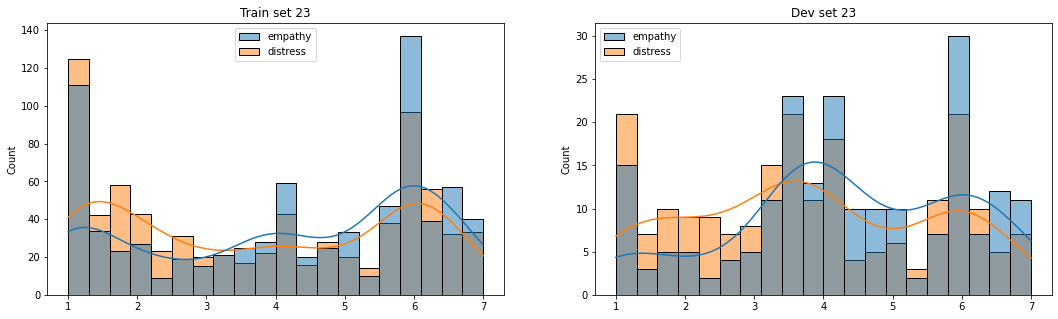

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(data=train_essay_data[["empathy", "distress"]], bins=20, kde=True, ax=ax1).set(title="Train set 23")
sns.histplot(data=dev_essay_data[["empathy", "distress"]], bins=20, kde=True, ax=ax2).set(title="Dev set 23")

[Text(0.5, 1.0, 'Dev set 22')]

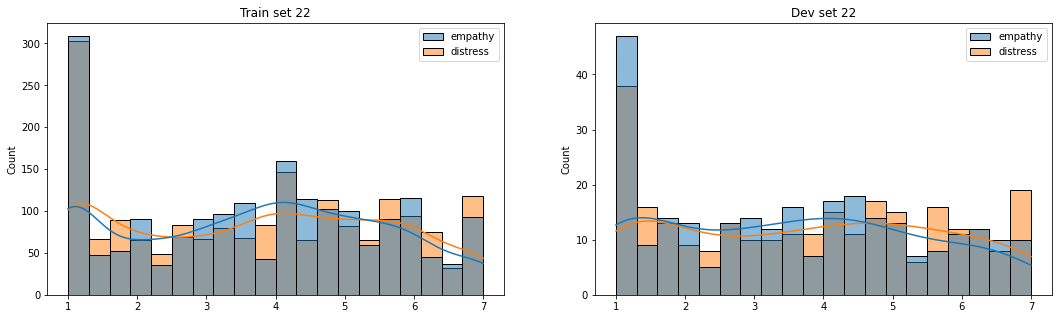

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(data=train_essay_data22[["empathy", "distress"]], bins=20, kde=True, ax=ax1).set(title="Train set 22")
sns.histplot(data=dev_essay_data22[["empathy", "distress"]], bins=20, kde=True, ax=ax2).set(title="Dev set 22")

In [25]:
print("# unique values for empathy in Train set: %d"%train_essay_data["empathy"].nunique())
print("# unique values for distress in Train set: %d"%train_essay_data["distress"].nunique())
print("# unique values for empathy in Dev set: %d"%dev_essay_data["empathy"].nunique())
print("# unique values for distress in Dev set: %d"%dev_essay_data["distress"].nunique())

# unique values for empathy in Train set: 37
# unique values for distress in Train set: 49
# unique values for empathy in Dev set: 35
# unique values for distress in Dev set: 46


Looking at some essays with low empathy

In [26]:
train_essay_data[train_essay_data['empathy']<=1][:10][['essay','article_id', 'empathy', 'distress']]

,essay,article_id,empathy,distress
3,"After reading the article, you just can't help but feel really sad for the boy and his family. It's so sad because he was just doing his family a favor by harvesting crops when he fell. It's so unfortunate as well because he was so young and he had his whole life ahead of him. Hopefully his parents are able to move on with life peacefully.",92,1.0,1.500
10,Reading about the attack on Paris that happened years ago brought up a lot of bad feelings and thoughts. I had completely forgotton about it because of how often things like that happen. It makes me upset to think that we are becoming numb to terror attacks in a way. i can only hope that the people affected have found peace and eventually we all will find peace,210,1.0,2.125
14,"Well while I am sorry for the people affected by this, it is never appropriate to protest on private land, block public highways, shoot guns at police, or throw rocks. These people do these things then act so shocked when the police react and suddenly they are the victims. Sorry, not in my book. If you hae an issue, you can contact politicians or go vote. Disrupting the peace and threatening the safety of others is not an appropriate response. it makes me mad.",273,1.0,1.125
16,"I don't understand why we now try to fight wars without civilian casualities. War is inherently ugly. It's inherently dirty. You can't fight it ""nice."" You don't do that unless you don't want to win. You fight ugly and you fight hard. We didn't win World War 2 by playing nice. We nuked Japan twice. We leveled Germany. Civilians are targets, too. These Yemeni allowed a rebel group backed by iran to take over and are now causing threats to Saudi Arabia. The Saudis shouldn't have to protect Yemeni citizens at the expense of their own citizens. They should fight as hard and destructively as they want. Fight to win the war, not to not ruffle feathers. Idiocy.",367,1.0,2.000
17,"Ehh I never really know what to think about claims like this. On the one hand, her roommates claim that they remember hearing her talk about it at the time. On the other hand, why wait twenty years to bring up an incident that happened that was that disturbing? I think some women are making allegations and accusations just to get attention or for political motivations. Who knows why. People do crazy things for crazy reasons. I'm just really skeptical of a lot of these things I hear and I think the #metoo movement has gotten way out of hand. Sorry, just my two cents.",128,1.0,1.125
23,"I don't have a major problem with limiting the areas people can smoke, particularly if the intent is to spare children from inhaling second-hand smoke. However, the idea that you'd do this so that children don't even see adults smoking seems absurd to me. I agree with the people calling this Orwellian, as if adults don't have the right to do legal things in public. Is no one allowed to drink in public, or at restaurants? Or is that ""normal"" and ""okay,"" while smoking isn't for some reason. This just seems arbitrary and consistent with typicial progressive fascism. These people have gone too far in trying to control things and bully legal things out of existence. It angers me.",113,1.0,3.125
28,Why isn't the EPA assessing fines for violations? So presently you just get a violation but no repercussions. Another example of ridiculous wasted government who sits on their behinds and doesn't do their job. I feel every year we need a completely new group of employees in every division in the government. It's ridiculous. The next most treasured commodity will be clean water everywhere.,218,1.0,5.375
30,"I can really get behind this ban. It disgusts me to see people smoking at playgrounds, and I've literally had to leave before because people were blowing smoke everywhere and I didn't want my children breathing it. It is just ridiculous. You can't tell me it's not harmful for a child to run through a cloud of smoke. On the same token, I though

Looking at some essays with high empathy

In [27]:
train_essay_data[train_essay_data['empathy']>=7][:10][['essay','article_id', 'empathy', 'distress']]

,essay,article_id,empathy,distress
66,I think that what happened with the dog was so sad and terrible. I honestly don't think that the police officer did that on purpose but rather it was just a terrible accident. It was stated that the dog has been working with the police officer for quite some time so i'm sure that they had some sort of bond. It's just really sad that such an innocent animal died because of this accident.,291,7.0,1.000
89,"This is so sad. I hadn't heard of this happening, but US strikes in Afghanistan ended up killing many civilians. One of the strikes actually hit an emergency hospital that Doctors without Borders was operating. A lot of the patients and the staff were killed. It just sounds horrible. Relatives were trying to walk through the streets with the bodies of their dead children. I can't even imagine what it would be like for these people.",13,7.0,5.750
119,This situation in Haiti is terrible and saddening. no person in this day and age should suffer at the hands of their government while no one does anything to help. It is sad to see such suffering and hungry people. How can a country be that terrible. How does next to nobody help these poor innocent people.,35,7.0,5.875
130,"This article really makes you think. Are the things we are doing to try to make the earth a healthier planet really helping? They are trying to make cleaner energy but in reality, they are killing off many birds. This is so sad, it's a catch 22. It seems that these wind energy generators are probably not the answer either. And the more that are made, it will just cause bigger problems.",398,7.0,6.625
142,"I feel so badly for this lady's family. They may not even realize that she is missing at the time of the article, but I'm sure they are already realizing that she is having problems with her memory. I have seen many family members with Alzheimer's, including my dad, and it is horrible to watch and to deal with.",245,7.0,2.750
172,This is an article about wildlife dying in Paraguay because of drought and mismanagement of the water resources. The area doesn't get water year round so they have to find ways to save water for the dry months. The dry area is between Argentina and Paraguay and currently Argentina has figured out ways to make the water last for them and is essentially taking the water and leaving the other side dry. I think it's sad and scary for the wildlife in the area.,397,7.0,4.750
174,This is a terrible story about an ISIS attack in Paris. It was at a concert and went on for hours. 90 people were killed. I feel so badly for the people who lost loved ones in the attack and for the people who had to go through it but survived. I can't imagine that life for them will ever be the same.,413,7.0,4.000
218,This is a story about a 12 year old girl in Russia who killed herself after spending time online with a group that promotes suicide. I feel so badly for the family and for the girl. A group like that should not be able to operate online and influence people to harm themselves. This is just so wrong.,305,7.0,5.375
219,"This is so sad. I can't even imagine living and trying to raise my family in a situation like this. These poor people can't even send their kids to school because they have to get up so early and stand in food lines. Or else the kids are too weak and sick from not eating, they can't go to school. Also, the school supplies are so expensive, they can't buy them because they need to buy food.",370,7.0,5.750
220,"Hey A: Did you read the article where all those children were killed on the roadway and the many injuries that took place? Kids were in a trailer and a truck plowed into the back of them. It was extremely disturbing to read. I could just visualize the pain, suffering, and panic that was taking place. I can't imagine losing 2 of your own children. Further reading showed the driver had lost her husband. Whoever was driving the truck will have to live with this the rest of their lives. It's extremel

Looking at some essays with low distress

In [28]:
train_essay_data[train_essay_data['distress']<=1][:10][['essay','article_id', 'empathy', 'distress']]

,essay,article_id,empathy,distress
5,This was sad and I hope they can do something about it. I hate that the wildlife is suffering since it is so innocent. Maybe the government should make more efforts to fix this situation or at least improve it. I get that it takes resources to do things but maybe they could find some small way to make a difference. It seems like the ecosystem is in serious danger if nothing is done so someone needs to act fast for the sake of the animals who are helpless victims of this situation.,397,1.500000,1.0
30,"I can really get behind this ban. It disgusts me to see people smoking at playgrounds, and I've literally had to leave before because people were blowing smoke everywhere and I didn't want my children breathing it. It is just ridiculous. You can't tell me it's not harmful for a child to run through a cloud of smoke. On the same token, I thought the argument that it was setting a bad example was stupid. Yes, it does set a bad example, but we can't just purge society of every bad example in an effort to protect people from life. It's up to parents to teach their kids right and wrong.",113,1.000000,1.0
51,"I honestly find this article more amusing than anything. I absolutely loathe birds. Can't stand them. Want them all dead. I don't even care how that affects the food chain or nature. I just can't stand birds. So the idea that they're so stupid they'll keep eating plastic and threaten their species' very existence, is amusing to me. I think the article also misses some important information that I'd be curious to know, but I also don't care that much. I also think it's amusing that Asian countries are all the worst at dumping plastics in the ocean. That's why the straw thing in the U.S. is missing the point. We're not the problem. The Asians are.",299,1.000000,1.0
66,I think that what happened with the dog was so sad and terrible. I honestly don't think that the police officer did that on purpose but rather it was just a terrible accident. It was stated that the dog has been working with the police officer for quite some time so i'm sure that they had some sort of bond. It's just really sad that such an innocent animal died because of this accident.,291,7.000000,1.0
67,"This is a sad case of what seems like an elderly woman getting lost. I feel sad for the family involved and the feelings they must have. Or did they even notice she was gone? You would think they would be out looking for her if they noticed. Maybe it was just a lonely old woman by herself which is even more sad. Either way, I feel like elderly people in general are often overlooked and that is unfortunate. They should deserve the same respect that younger people do",245,2.166667,1.0
69,"After reading the article, my reaction is that it is very sad that boys that young have to be put behind bars. I think that children should be able to experience their childhood and have fun at that age. They should not be facing hardships at all. They should be playing with friends and be in school at that age and not locked up behind a cell.",78,1.500000,1.0
88,"I found it a little hard to relate to this situation. It seems so far away and I can't really connect with any of the people involved. I'm really sad for these families and their children. It seems like they are in a difficult position without much option or anything they can do about it. I hope they are able to find some resolution or some solution, but it doesn't seem like much is going to change there anytime soon. I don't think this is the problem of the United States and we should remain uninvolved.",34,1.500000,1.0
91,"This is pretty sad for the elephant. It obviously has no say so in this matter and that is not okay. Elephants are very intelligent and sensitive animals. They shouldn't be kept in captivity in these circuses and shows I do not think. This seems inhumane and not right. I would feel guilty going to a circus seeing elephants parade around. Maybe at a zoo where they cou

Looking at some essays with high distress

In [29]:
train_essay_data[train_essay_data['distress']>=7][:10][['essay','article_id', 'empathy', 'distress']]

,essay,article_id,empathy,distress
19,It bothers me so much that we are polluting our oceans to begin with and then to see that we are harming even more animals because of it. It seems crazy that plastic floating in the ocean can be harming sea birds but it also does make some sense. Just more humans doing harm to things that we had no business messing with to begin with. I am so angered over this and upset to think of the damage our garbage is causing.,299,4.833333,7.0
42,I'm so tired of all this violence. If a cop shoots someone suddenly it's acceptable to go around and commit violence or loot and steal. We start reacting before we even know the facts of the situation and we place all the blame on officers as if they are just looking to shoot people. We don't hear all the stories about officers being shot every day. We don't see riots and protests when another cop is shot by a supposedly unarmed suspect. It's time we start fairly representing both sides of a situation.,201,4.833333,7.0
68,this situation is so sad. The things that are going on in syria break my heart Reading the terrible unimaginable story of children covered in dust and blood is so sad. Reading that children are being killed along with hundreds of others is so sad. This is truly a horrible situation that needs more attention so more can help.,7,6.000000,7.0
229,"After reading about this disaster I'm just heart broken. It's so sad to think that one incident can impact an entire area and impact so many people for so long. That river will never be the same and there is nothing anyone can do now but wait and hope that someday, things might be better. But now all those people are without water and work. Generations of fisherman can't fish there. Fish isn't safe to eat. It's beyond sad.",134,4.166667,7.0
281,"This is the saddest article ever. All these beautiful Savannah Elephants being called for the ivory.I absolutely do not support killing any elephant for any reason. I do not support elephants in circuses either. As long as their are humans, this will sadly continue. Everyone is me, me, me. I hope huge fines as assessed.",72,7.000000,7.0
400,"We shouldn't be wasting food like that us Americans when there are so many starving children around the world. We need to find a way to preserve leftover food , renew it and give it to the people in need. It can be the homeless or children in need. The bottom line is we need to make better use of the food so other people can enjoy it.",53,1.000000,7.0
474,"The government of India makes a lot of money from coal production, but they do not take into account who this is affecting the most. Both the people and the elephants are being hit the hardest, not to mention the forests that are being destroyed. There have been 75 deaths of people and 30 deaths of elephants. People are having respiratory problems. Just imagine the children being affected. It's a travesty. People need clean air and water to live and it's like the government doesn't care. Someone needs to step up and do something.",336,7.000000,7.0
541,"This article is so shocking and just stomach churning to me. How could your own flesh and blood do such horrible acts to you, a little girl. They stole her innocense and trust in people. They deserve life in jail the fact that they are out is just absurd. If they could do this to there own child i think they are to be considered at risk to other children and the community. It shows they have no moral compass and consious. I feel for that girl how you could ever live a normal life or create real relationships after being used for sex for so long is beyond me. I hope she has gotten appropriate therapy and other family to help her through. What a strong girl to go against her parents and stand up for herself.",91,7.000000,7.0
552,How can your heart just not break reading this article. These children had there life cut way to short for no reason. This father was just pure evil. He needed serious mental help and I can't believ

Correlation analysis

In [30]:
emp_dist_pearson = stats.pearsonr(train_essay_data['empathy'], train_essay_data['distress'])
print(f"Pearson correlation between empathy and distress: {emp_dist_pearson[0]}; P-value: {emp_dist_pearson[1]}")

Pearson correlation between empathy and distress: 0.6237673272854213; P-value: 3.266218030937429e-85


[]

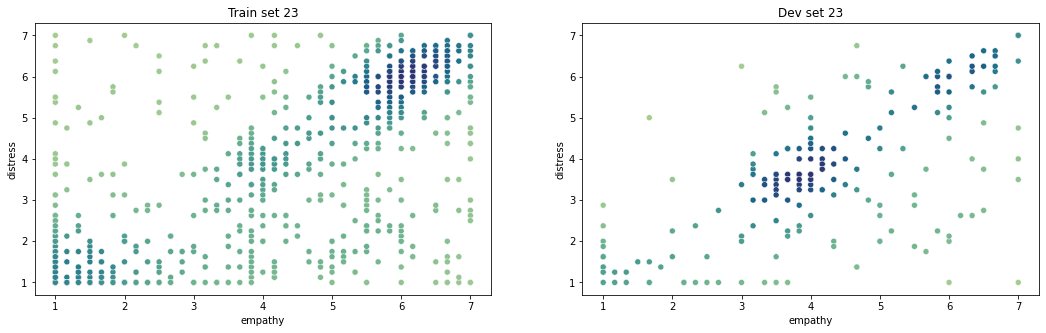

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

values = np.vstack([train_essay_data["empathy"], train_essay_data["distress"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='empathy', y='distress', data=train_essay_data, c=kernel, cmap="crest", ax=ax1).set(title='Train set 23')

values = np.vstack([dev_essay_data["empathy"], dev_essay_data["distress"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='empathy', y='distress', data=dev_essay_data, c=kernel, cmap="crest", ax=ax2).set(title='Dev set 23')

plt.plot()

[]

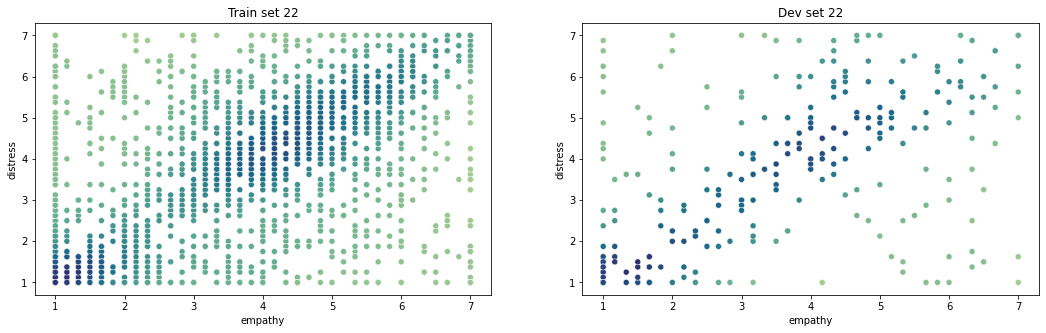

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

values = np.vstack([train_essay_data22["empathy"], train_essay_data22["distress"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='empathy', y='distress', data=train_essay_data22, c=kernel, cmap="crest", ax=ax1).set(title='Train set 22')

values = np.vstack([dev_essay_data22["empathy"], dev_essay_data22["distress"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='empathy', y='distress', data=dev_essay_data22, c=kernel, cmap="crest", ax=ax2).set(title='Dev set 22')

plt.plot()

Coorelation between lexical empathy and distress counts and targets

[]

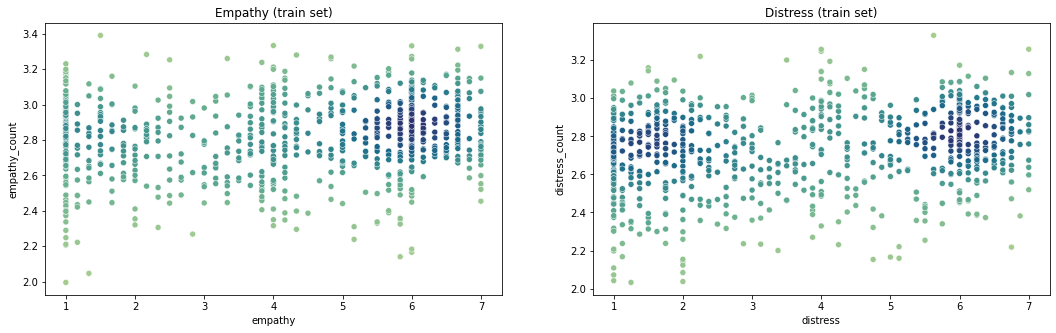

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

values = np.vstack([train_essay_data["empathy"], train_essay_data["empathy_count"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='empathy', y='empathy_count', data=train_essay_data, c=kernel, cmap="crest", ax=ax1).set(title='Empathy (train set)')

values = np.vstack([train_essay_data["distress"], train_essay_data["distress_count"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(x='distress', y='distress_count', data=train_essay_data, c=kernel, cmap="crest", ax=ax2).set(title='Distress (train set)')

plt.plot()

In [34]:
emp_lex_corr = stats.pearsonr(train_essay_data['empathy'], train_essay_data['empathy_count'])
dist_lex_corr = stats.pearsonr(train_essay_data['distress'], train_essay_data['distress_count'])
print(f"Correlation between targets and lexical features for empathy:{emp_lex_corr}")
print(f"Correlation between targets and lexical features for distress:{dist_lex_corr}")

Correlation between targets and lexical features for empathy:(0.169584594179424, 1.934763450436182e-06)
Correlation between targets and lexical features for distress:(0.21045502340964847, 3.0102699240978733e-09)


Plot empathy and distress counts from lexicon

[]

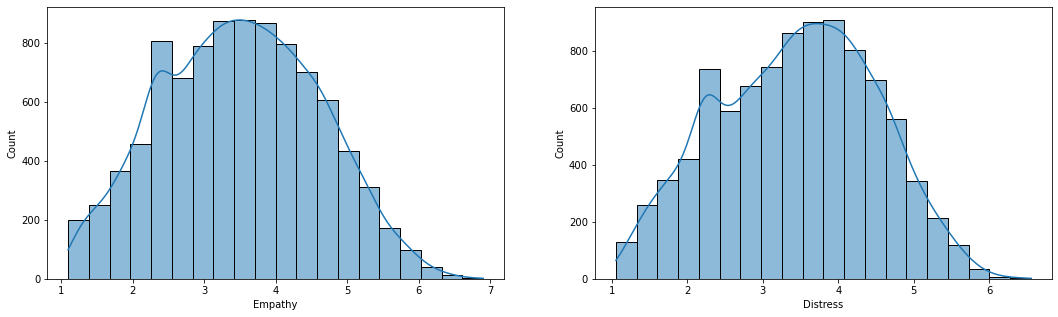

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

empathy_lex = pd.read_csv('./lexicon/empathy.txt', header=None)
distress_lex = pd.read_csv('./lexicon/distress.txt', header=None)

sns.histplot(data=empathy_lex[1], bins=20, kde=True, ax=ax1).set(xlabel='Empathy')
sns.histplot(data=distress_lex[1], bins=20, kde=True, ax=ax2).set(xlabel='Distress')

plt.plot()

[]

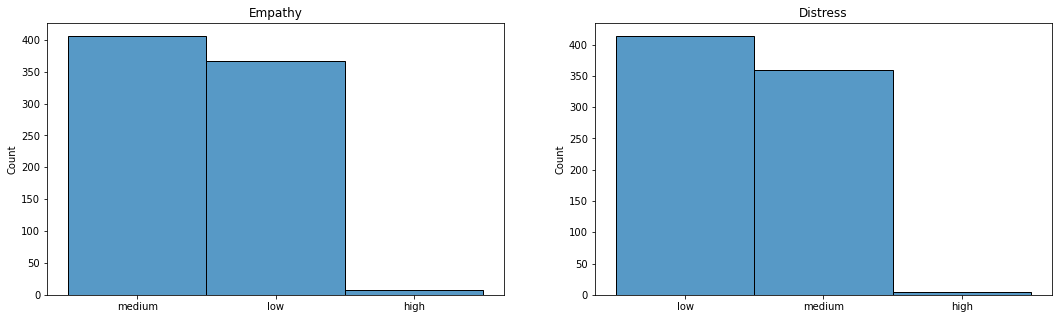

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=train_essay_data['empathy_level'], ax=ax1).set(title="Empathy", xlabel='')
sns.histplot(data=train_essay_data['distress_level'], ax=ax2).set(title="Distress", xlabel='')

plt.plot()

In [37]:
empathy_level_true = []
distress_level_true = []

for emp, dist in zip(train_essay_data['empathy'], train_essay_data['distress']):
    if emp < 3:
        empathy_level_true.append('low')
    elif emp >= 3 and emp <= 4:
        empathy_level_true.append('medium')
    else:
        empathy_level_true.append('high')
    if dist < 3:
        distress_level_true.append('low')
    elif dist >= 3 and dist <= 4:
        distress_level_true.append('medium')
    else:
        distress_level_true.append('high')

<AxesSubplot:>

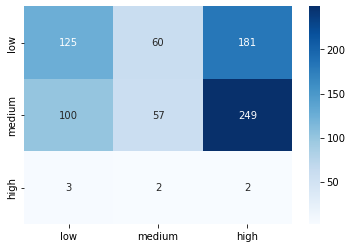

In [38]:
labels = ['low', 'medium', 'high']
cm_df = pd.DataFrame(confusion_matrix(train_essay_data['empathy_level'], empathy_level_true, labels=labels),index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')

<AxesSubplot:>

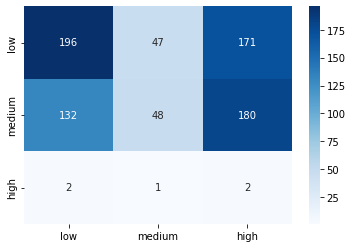

In [39]:
cm_df = pd.DataFrame(confusion_matrix(train_essay_data['distress_level'], distress_level_true, labels=labels),index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')

2023-07-21 09:09:48.462233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


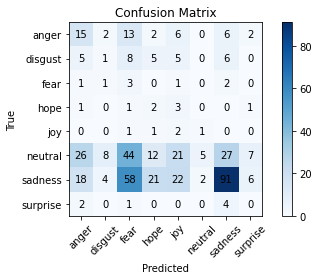

In [40]:
from utils import plot_confusion_matrix_per_emotions

def extract_emotions(input_string): 
	words = input_string.strip()
	words = words.replace(".", "")
	words = words.replace(", ", "/")
	return words
	
lex_emotions = train_essay_data['prompt_emo'].str.split(':').str[1]
lex_emotions_strings = []
for emo in lex_emotions:
	emo = extract_emotions(emo)
	lex_emotions_strings.append(emo)

plot_confusion_matrix_per_emotions(train_essay_data['emotion'], lex_emotions_strings)

Correlation between empathy, distress and emotions

[Text(0.5, 1.0, 'Correlation between empathy, distress and emotion')]

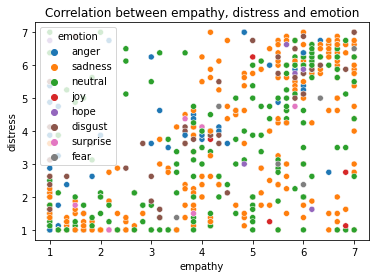

In [41]:
sns.scatterplot(
    x='empathy', y='distress',
    data=train_essay_data[train_essay_data['multiple_emotions']=='No'],
    hue='emotion',
    ).set(title='Correlation between empathy, distress and emotion')

[]

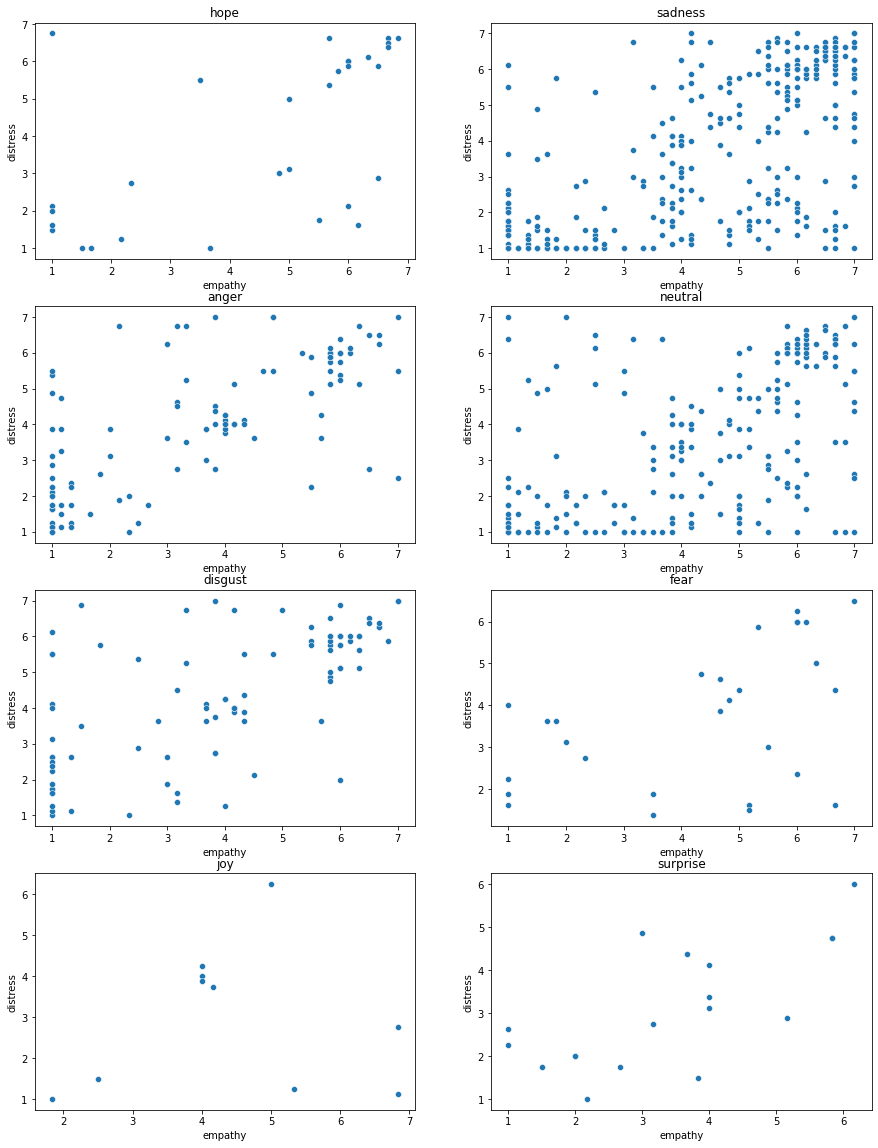

In [42]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
for i, emotion in enumerate(emotions):
    plt.subplot(4, 2, i+1)
    sns.scatterplot(
    x='empathy', y='distress',
    data=train_essay_data[train_essay_data[emotion]==1]
    ).set(title=f'{emotion}')
plt.plot()

## Demographical features exploration

Gender statistics

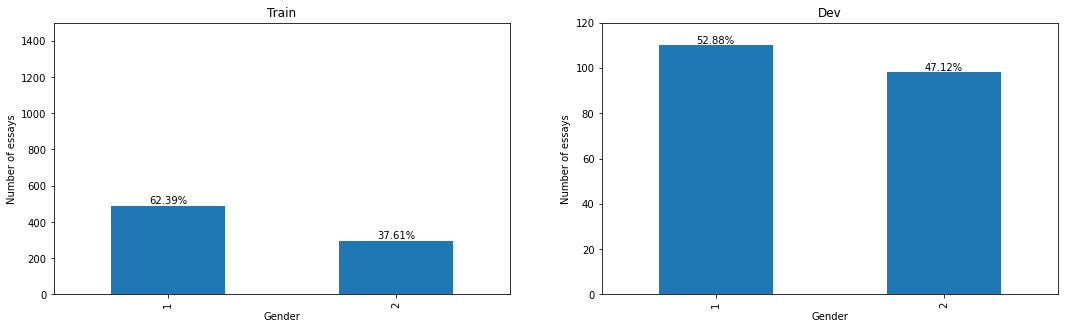

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
train_essay_data['gender'].value_counts().plot(kind='bar', title="Train", xlabel='Gender', ylabel='Number of essays', ax=ax1)
add_percentages(ax1, len(train_essay_data['gender']), 1500, 15, rotation=0)
dev_essay_data['gender'].value_counts().plot(kind='bar', title="Dev", xlabel='Gender', ylabel='Number of essays', ax=ax2)
add_percentages(ax2, len(dev_essay_data['gender']), 120, 1, rotation=0)

Education statistics

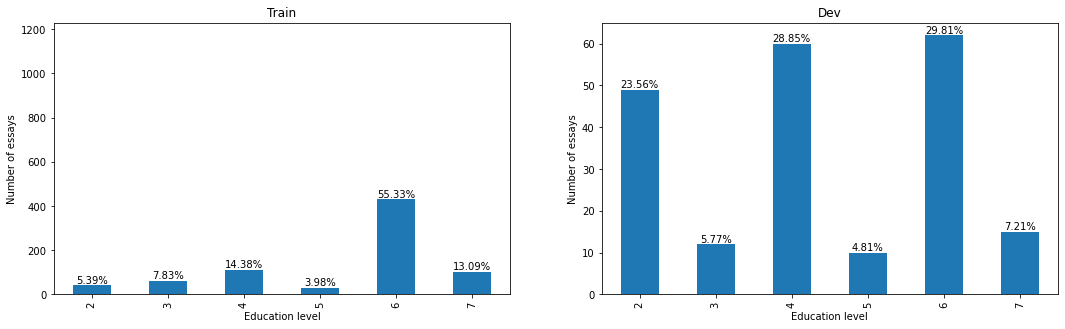

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
train_essay_data['education'].value_counts().sort_index().plot(kind='bar', title="Train", xlabel='Education level', ylabel='Number of essays', ax=ax1)
add_percentages(ax1, len(train_essay_data['education']), 1230, 10, rotation=0)
dev_essay_data['education'].value_counts().sort_index().plot(kind='bar', title="Dev", xlabel='Education level', ylabel='Number of essays', ax=ax2)
add_percentages(ax2, len(dev_essay_data['education']), 65, 0.5, rotation=0)

Race statistics

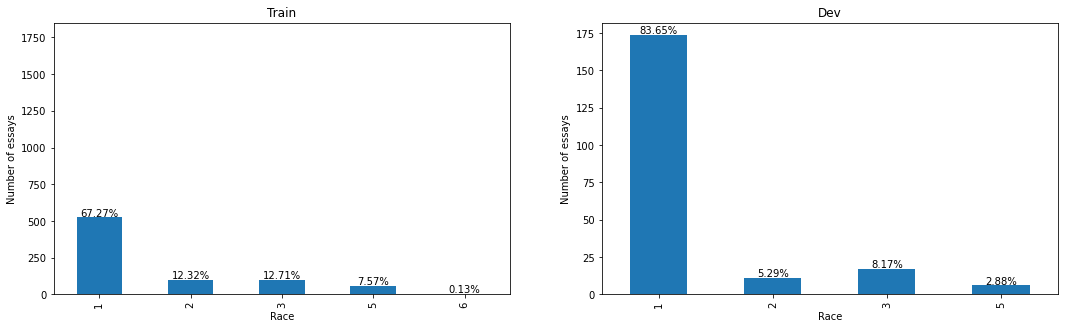

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
train_essay_data['race'].value_counts().sort_index().plot(kind='bar', title="Train", xlabel='Race', ylabel='Number of essays', ax=ax1)
add_percentages(ax1, len(train_essay_data['race']), 1850, 10, rotation=0)
dev_essay_data['race'].value_counts().sort_index().plot(kind='bar', title="Dev", xlabel='Race', ylabel='Number of essays', ax=ax2)
add_percentages(ax2, len(dev_essay_data['race']), 182, 1, rotation=0)

Age statistics

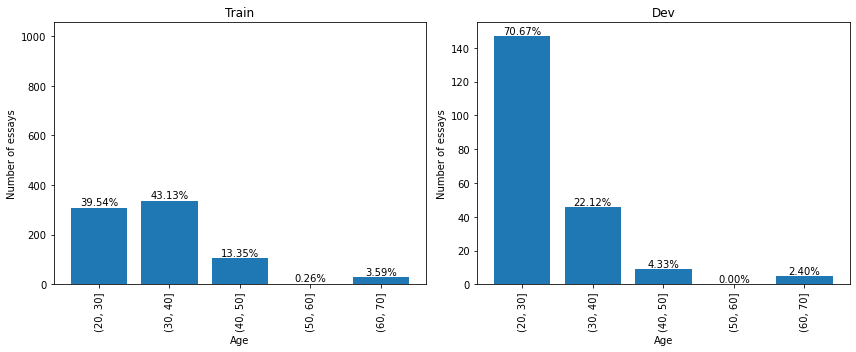

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

age_bins = [20, 30, 40, 50, 60, 70]

train_essay_data['age'] = pd.to_numeric(train_essay_data['age'], errors='coerce')
train_age_counts = pd.cut(train_essay_data['age'], age_bins).value_counts().sort_index()

dev_essay_data['age'] = pd.to_numeric(dev_essay_data['age'], errors='coerce')
dev_age_counts = pd.cut(dev_essay_data['age'], age_bins).value_counts().sort_index()

ax1.bar(train_age_counts.index.astype(str), train_age_counts.values)
ax1.set_title('Train')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of essays')
add_percentages(ax1, len(train_essay_data['age']), 1055, 10, rotation=0)

ax2.bar(dev_age_counts.index.astype(str), dev_age_counts.values)
ax2.set_title('Dev')
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of essays')
add_percentages(ax2, len(dev_essay_data['age']), 155, 1, rotation=0)

ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Income statistics

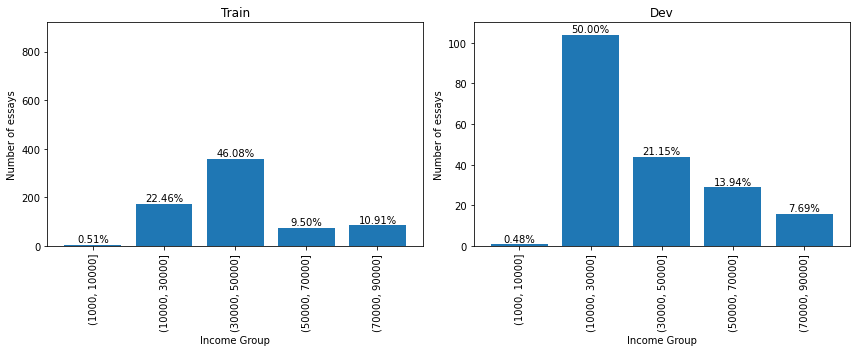

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

income_bins = [1000, 10000, 30000, 50000, 70000, 90000]

train_essay_data['income'] = pd.to_numeric(train_essay_data['income'], errors='coerce')
train_income_counts = pd.cut(train_essay_data['income'], income_bins).value_counts().sort_index()

dev_essay_data['income'] = pd.to_numeric(dev_essay_data['income'], errors='coerce')
dev_income_counts = pd.cut(dev_essay_data['income'], income_bins).value_counts().sort_index()

ax1.bar(train_income_counts.index.astype(str), train_income_counts.values)
ax1.set_title('Train')
ax1.set_xlabel('Income Group')
ax1.set_ylabel('Number of essays')
add_percentages(ax1, len(train_essay_data['income']), 920, 10, rotation=0)

ax2.bar(dev_income_counts.index.astype(str), dev_income_counts.values)
ax2.set_title('Dev')
ax2.set_xlabel('Income Group')
ax2.set_ylabel('Number of essays')
add_percentages(ax2, len(dev_essay_data['income']), 110, 1, rotation=0)

ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

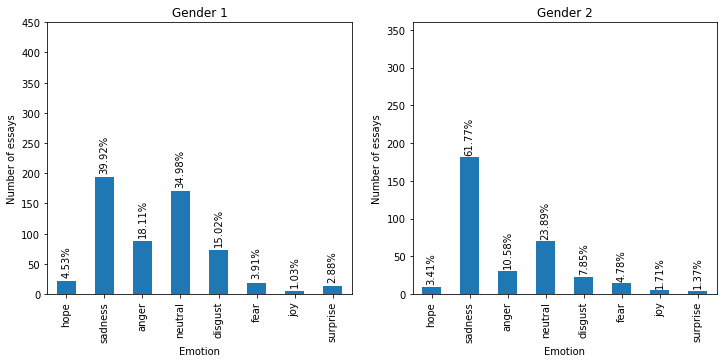

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_essay_data[train_essay_data['gender']==1][emotions].sum().plot(
	kind='bar',
	xlabel='Emotion',
	ylabel='Number of essays',
	title='Gender 1',
	ax=ax1
	)
add_percentages(ax1, len(train_essay_data[train_essay_data['gender']==1]), 450, 10, rotation=90)
train_essay_data[train_essay_data['gender']==2][emotions].sum().plot(
	kind='bar',
	xlabel='Emotion',
	ylabel='Number of essays',
	title='Gender 2',
	ax=ax2
	)
add_percentages(ax2, len(train_essay_data[train_essay_data['gender']==2]), 360, 6, rotation=90)

[Text(0.5, 1.0, 'Gender 2')]

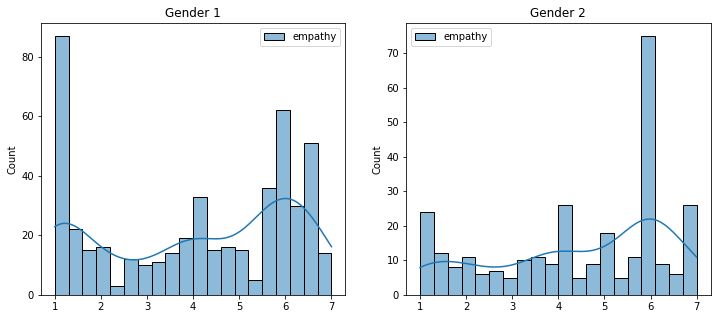

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=train_essay_data[train_essay_data['gender']==1][["empathy"]], bins=20, kde=True, ax=ax1).set(title="Gender 1")
sns.histplot(data=train_essay_data[train_essay_data['gender']==2][["empathy"]], bins=20, kde=True, ax=ax2).set(title="Gender 2")

Compute correlations between targets and demographical features

In [50]:
targets = ['empathy', 'distress'] + emotions

def compute_correlation(data, attr):
    correlations = {}
    for target in targets:
        if target != 'empathy' and target != 'distress':
            targets_col = data[target].astype('category').cat.codes
        else:
            targets_col = data[target]
        if attr == 'age' or attr == 'income':
            attr_col = data[attr]
        else:
            attr_col = data[attr].astype('category').cat.codes
        correlations[target] = stats.pearsonr(
            attr_col,
            targets_col,
        )
    correlations_df = pd.DataFrame(correlations).T
    correlations_df.columns = ['pearson', 'p-value']
    correlations_df.sort_values(by='pearson', ascending=False, inplace=True)
    return correlations_df

In [51]:
compute_correlation(train_essay_data, 'gender')

,pearson,p-value
sadness,0.211903,2.332255e-09
empathy,0.098935,5.715229e-03
joy,0.029162,4.163417e-01
fear,0.020893,5.603982e-01
distress,0.011123,7.565910e-01
hope,-0.027184,4.486622e-01
surprise,-0.048862,1.730751e-01
anger,-0.101348,4.633902e-03
disgust,-0.105675,3.147300e-03
neutral,-0.116340,1.142087e-03


In [52]:
compute_correlation(train_essay_data, 'age')

,pearson,p-value
anger,0.120123,0.000781
joy,0.054004,0.132077
distress,0.051363,0.152084
empathy,0.042353,0.237713
neutral,0.015452,0.666756
sadness,-0.028146,0.432767
surprise,-0.035031,0.328834
disgust,-0.041604,0.246115
fear,-0.043089,0.229651
hope,-0.046057,0.199107


In [53]:
compute_correlation(train_essay_data, 'income')

,pearson,p-value
sadness,0.126062,0.000420
disgust,0.014210,0.692114
empathy,-0.002494,0.944591
hope,-0.009154,0.798653
neutral,-0.013138,0.714273
joy,-0.036599,0.307636
fear,-0.039406,0.271984
surprise,-0.051651,0.149796
anger,-0.105378,0.003233
distress,-0.135831,0.000143


In [54]:
compute_correlation(train_essay_data, 'education')

,pearson,p-value
sadness,0.072082,0.044299
anger,0.033677,0.347883
joy,0.020462,0.568515
neutral,-0.019642,0.584112
surprise,-0.033236,0.354234
disgust,-0.033733,0.347079
hope,-0.076577,0.032597
distress,-0.110551,0.002001
fear,-0.114135,0.001418
empathy,-0.171129,0.000002


In [55]:
compute_correlation(train_essay_data, 'race')

,pearson,p-value
empathy,0.189405,1.002962e-07
joy,0.103506,3.827276e-03
distress,0.076239,3.337441e-02
hope,0.075757,3.450944e-02
neutral,0.075572,3.495553e-02
anger,0.012512,7.273462e-01
surprise,0.000212,9.952759e-01
disgust,-0.037972,2.898217e-01
fear,-0.046280,1.969390e-01
sadness,-0.080309,2.499333e-02
